# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
#define the import statements we need for this project
import os
import random
import requests
import time
import ast
import numpy as np
from glob import glob
import cv2                
from tqdm import tqdm
from PIL import Image, ImageFile 

#we will use the torch library mainly
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

import matplotlib.pyplot as plt                        
%matplotlib inline

ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()


import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


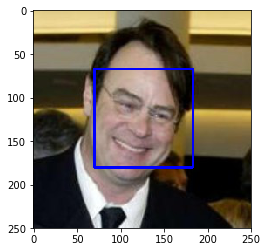

In [8]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [32]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
count_humans = 0 
count_dogs = 0

for file in human_files_short:
    if face_detector(file) == True:
        count_humans += 1
        
for file in dog_files_short:
    if face_detector(file) == True:
        count_dogs += 1

print('%.1f%% images of the first 100 human_files were detected as human face.' % count_humans)
print('%.1f%% images of the first 100 dog_files were detected as human face.' % count_dogs)


98.0% images of the first 100 human_files were detected as human face.
17.0% images of the first 100 dog_files were detected as human face.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [12]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 80945910.91it/s]


In [13]:
#get an impression of the model architecture
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [14]:
def load_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    # resize our images to (244, 244) because VGG16 requires this shape
    in_transform = transforms.Compose([
                        transforms.Resize(size=(244, 244)),
                        transforms.ToTensor()]) # normalizaiton parameters from pytorch doc.

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [15]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img = load_image(img_path)
    if use_cuda:
        img = img.cuda()
    ret = VGG16(img)
    return torch.max(ret,1)[1].item() # predicted class index

In [23]:
def image_to_tensor(img_path):
    '''
    As per Pytorch documentations: All pre-trained models expect input images normalized in the same way, 
    i.e. mini-batches of 3-channel RGB images
    of shape (3 x H x W), where H and W are expected to be at least 224. 
    The images have to be loaded in to a range of [0, 1] and 
    then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
    You can use the following transform to normalize:
    '''
    img = Image.open(img_path).convert('RGB')
    transformations = transforms.Compose([transforms.Resize(size=224),
                                          transforms.CenterCrop((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    image_tensor = transformations(img)[:3,:,:].unsqueeze(0)
    return image_tensor


# helper function for un-normalizing an image  - from STYLE TRANSFER exercise
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

torch.Size([1, 3, 224, 224])


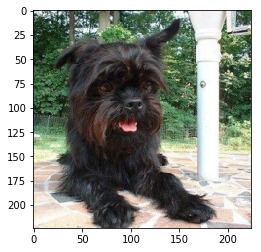

In [24]:
test_tensor = image_to_tensor('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')
# print(test_tensor)
print(test_tensor.shape)
plt.imshow(im_convert(test_tensor))

In [25]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    image_tensor = image_to_tensor(img_path)
   
    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = VGG16(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
 
    return int(pred)


In [26]:
LABELS_MAP_URL = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/c2c91c8e767d04621020c30ed31192724b863041/imagenet1000_clsid_to_human.txt"

def get_human_readable_label_for_class_id(class_id):
    labels = ast.literal_eval(requests.get(LABELS_MAP_URL).text)
    print(f"Label:{labels[class_id]}")
    return labels[class_id]

test_prediction = VGG16_predict('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')
pred_class = int(test_prediction)

print(f"Predicted class id: {pred_class}")
class_description = get_human_readable_label_for_class_id(pred_class)
print(f"Predicted class for image is *** {class_description.upper()} ***")

Predicted class id: 252
Label:affenpinscher, monkey pinscher, monkey dog
Predicted class for image is *** AFFENPINSCHER, MONKEY PINSCHER, MONKEY DOG ***


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [43]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    prediction = VGG16_predict(img_path)
    #print(prediction)
    return ((prediction >= 151) & (prediction <=268))

In [44]:
print(dog_detector(dog_files_short[1]))
print(dog_detector(human_files_short[1]))

True
False


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [45]:
human_detected = 0.0
dog_detected = 0.0

num_files = len(human_files_short)

for i in range(0, num_files):
    human_path = human_files_short[i]
    dog_path = dog_files_short[i]
    
    if dog_detector(human_path) == True:
        human_detected += 1
    if dog_detector(dog_path) == True:
        dog_detected += 1

print('VGG-16 Prediction')
print('The percentage of the detected dog - Humans: {0:.0%}'.format(human_detected / num_files))
print('The percentage of the detected dog - Dogs: {0:.0%}'.format(dog_detected / num_files))

#different notation
print("detect a dog in human_files: {} / {}".format(dog_detector_test(human_files_short)[0], dog_detector_test(human_files_short)[1]))
print("detect a dog in dog_files: {} / {}".format(dog_detector_test(dog_files_short)[0], dog_detector_test(dog_files_short)[1]))

VGG-16 Prediction
The percentage of the detected dog - Humans: 1%
The percentage of the detected dog - Dogs: 100%
detect a dog in human_files: 1 / 100
detect a dog in dog_files: 100 / 100


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [46]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes


# how many samples per batch to load
batch_size = 16

# number of subprocesses to use for data loading
num_workers = 2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([transforms.Resize(size=224),
                                transforms.CenterCrop((224,224)),
                                transforms.RandomHorizontalFlip(), 
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define training, test and validation data directories
data_dir = '/data/dog_images/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform)
                  for x in ['train', 'valid', 'test']}
loaders_scratch = {
    x: torch.utils.data.DataLoader(image_datasets[x], shuffle=True, batch_size=batch_size, num_workers=num_workers)
    for x in ['train', 'valid', 'test']}


In [47]:
class_names = image_datasets['train'].classes
nb_classes = len(class_names)

print("Number of classes:", nb_classes)
print("\nClass names: \n\n", class_names)

Number of classes: 133

Class names: 

 ['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_terrier', '040.Bulldog', '041.Bullmastiff', '042.Cairn_terrier', '043.Canaan_dog'

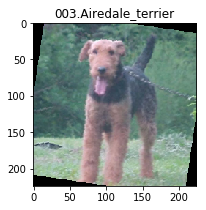

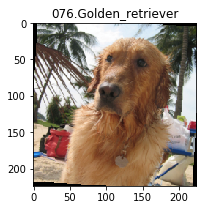

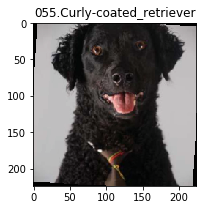

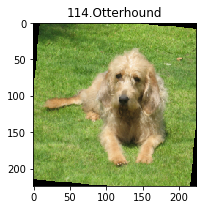

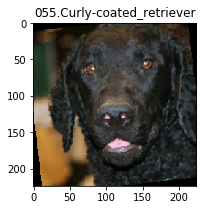

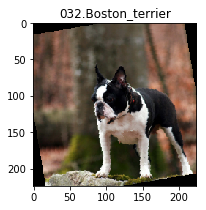

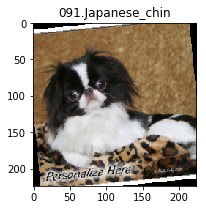

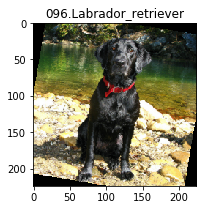

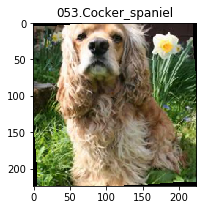

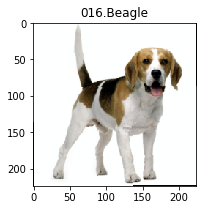

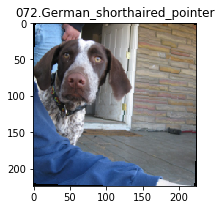

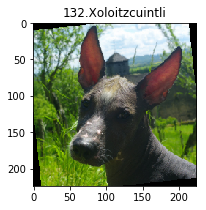

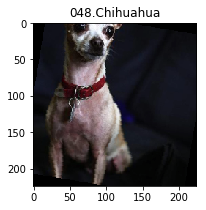

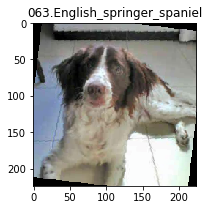

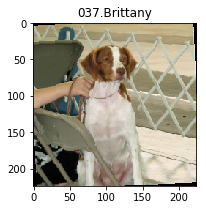

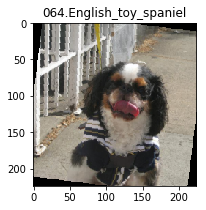

In [48]:
#show some images in with the associated classes
inputs, classes = next(iter(loaders_scratch['train']))

for image, label in zip(inputs, classes): 
    image = image.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
     
    fig = plt.figure(figsize=(12,3))
    plt.imshow(image)
    plt.title(class_names[label])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: 
I normalized the images to the size of 224x224 pixels in order to make it processable in my convolutional neural network. I used the transforms.resize() function, as most of the images are naturally to big to just use them in a CNN.

I used the RondomHorizontalFlip() and the RandomRotation() methods in order to augment the data and improve our training results.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [22]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Size 224
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # Size 112
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        # Size 56
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        # Size 28
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        # Size 14
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.batch_norm256 = nn.BatchNorm2d(256)
        self.batch_norm512 = nn.BatchNorm2d(512)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout()
        
        # Size 7
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        # The Last fully connected layer's output is 133(Number of breeds)
        self.fc3 = nn.Linear(4096, 133)
    
    # Feedforward
    def forward(self, x):
        x = self.relu(self.batch_norm64(self.conv1_1(x)))
        x = self.relu(self.batch_norm64(self.conv1_2(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm128(self.conv2_1(x)))
        x = self.relu(self.batch_norm128(self.conv2_2(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm256(self.conv3_1(x)))
        x = self.relu(self.batch_norm256(self.conv3_2(x)))
        x = self.relu(self.batch_norm256(self.conv3_3(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm512(self.conv4_1(x)))
        x = self.relu(self.batch_norm512(self.conv4_2(x)))
        x = self.relu(self.batch_norm512(self.conv4_3(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm512(self.conv5_1(x)))
        x = self.relu(self.batch_norm512(self.conv5_2(x)))
        x = self.relu(self.batch_norm512(self.conv5_3(x)))
        x = self.max_pool(x)
        
        # It returns a new tensor which has a different size
        # and it's the same data of self tensor
        # The -1 means inferring the size from other dimensions.
        x = x.view(x.size(0), -1)
        
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
#-#-# You so NOT have to modify the code below this line. #-#-#    
    
# Create CNN instance!
model_scratch = Net()

# If CUDA is avaliable, Move Tensors to GPU
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 
The inspiration for my model was the architecture of VGG-16.
I used several convolutional layers to extract the features of the pictures.
Then i applied batch Normalization as a technique to improve performance and stability of the CNN. It provides zero mean and unit variance as inputs to any layers. For the output layers I decided to take ReLu functions, as these are the de-facto standard for multi-class classification problems.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [39]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()
### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [41]:
### TODO: select loss function
def train(n_epochs, train_loader, valid_loader,
          model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # calculate batch loss
            loss = criterion(output, target)
            # backward pass
            loss.backward()
            # parameter update
            optimizer.step()
            # update training loss
            train_loss += loss.item() * data.size(0)
            
        ######################
        # validate the model #
        ######################
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## update the average validation loss
            
            # forward pass
            output = model(data)
            # batch loss
            loss = criterion(output, target)
            # update validation loss
            valid_loss += loss.item() * data.size(0)
        
        # calculate average losses
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)
        
        # print training/validation statistics 
        print('Epoch: {}\tTraining Loss: {:.6f}\t Validation Loss: {:.6f}'.
             format(epoch, train_loss, valid_loss))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).    Saving model...'.
                 format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    
    # return trained model
    return model 

In [45]:
n_epochs = 10
# train the model
model_scratch = train(n_epochs, loaders_scratch['train'], loaders_scratch['valid'], model_scratch,
                     optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1	Training Loss: 0.806750	 Validation Loss: 3.306621
Validation loss decreased (inf --> 3.306621).    Saving model...
Epoch: 2	Training Loss: 0.691060	 Validation Loss: 3.829577
Epoch: 3	Training Loss: 0.608318	 Validation Loss: 3.953822
Epoch: 4	Training Loss: 0.513764	 Validation Loss: 4.070856
Epoch: 5	Training Loss: 0.420990	 Validation Loss: 4.727158
Epoch: 6	Training Loss: 0.374484	 Validation Loss: 4.403588
Epoch: 7	Training Loss: 0.302632	 Validation Loss: 4.957479
Epoch: 8	Training Loss: 0.293350	 Validation Loss: 4.889192
Epoch: 9	Training Loss: 0.235144	 Validation Loss: 5.014364
Epoch: 10	Training Loss: 0.197017	 Validation Loss: 5.337653


In [46]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [24]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        
        # update average test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        # print testing statistics 
            
    # calculate average loss
    test_loss = test_loss/len(loaders['test'].dataset)
        
    # print test statistics 
    print('Testing Loss Average: {:.6f} '.format(test_loss))
    
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [48]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Testing Loss Average: 3.233929 

Test Accuracy: 35% (298/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [10]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [49]:
## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 123286695.15it/s]


In [12]:
for param in model_transfer.parameters():
    param.requires_grad = False

In [13]:
model_transfer.fc = nn.Linear(2048, 133, bias=True)

In [14]:
fc_parameters = model_transfer.fc.parameters()

In [15]:
for param in fc_parameters:
    param.requires_grad = True

In [16]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [17]:
if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
The most efficient way to tackle classification problems, especially if your computational capacities are limited, is to use pretrained models. The ResNet50 turned out to be very efficient for this task, so I decided to implement it here. It is pretrained on the popular ImageNet dataset, so it isn´t specifically trained for our dog breed problem. To use it for our porpuse, we need to substitute the classfier (model_transfer.fc = nn.Linear(2048, 133, bias=True))

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [18]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

The CrossEntropyLoss function combines :func:nn.LogSoftmax and :func:nn.NLLLoss in one single class and is useful when training a classification problem with C classes.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [19]:
# train the model
# train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [21]:
train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch 1, Batch 1 loss: 4.775198
Epoch 1, Batch 101 loss: 4.568367
Epoch 1, Batch 201 loss: 4.530114
Epoch 1, Batch 301 loss: 4.496845
Epoch 1, Batch 401 loss: 4.464025
Epoch: 1 	Training Loss: 4.456829 	Validation Loss: 4.226810
Validation loss decreased (inf --> 4.226810).  Saving model ...
Epoch 2, Batch 1 loss: 4.289004
Epoch 2, Batch 101 loss: 4.255263
Epoch 2, Batch 201 loss: 4.231609
Epoch 2, Batch 301 loss: 4.211631
Epoch 2, Batch 401 loss: 4.185632
Epoch: 2 	Training Loss: 4.179043 	Validation Loss: 3.934914
Validation loss decreased (4.226810 --> 3.934914).  Saving model ...
Epoch 3, Batch 1 loss: 3.945165
Epoch 3, Batch 101 loss: 3.981511
Epoch 3, Batch 201 loss: 3.966060
Epoch 3, Batch 301 loss: 3.945142
Epoch 3, Batch 401 loss: 3.915103
Epoch: 3 	Training Loss: 3.911092 	Validation Loss: 3.646091
Validation loss decreased (3.934914 --> 3.646091).  Saving model ...
Epoch 4, Batch 1 loss: 3.817985
Epoch 4, Batch 101 loss: 3.738706
Epoch 4, Batch 201 loss: 3.733442
Epoch 4, Ba

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [22]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [25]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Testing Loss Average: 1.353123 

Test Accuracy: 77% (652/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [26]:
# CPU or GPU
device = torch.device("cuda:0" if use_cuda else "cpu")

# Load the trained model 'model_transfer.pt'
model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location='cpu'))

In [28]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def predict_breed_transfer(img_path):
    # class names without number (Affenpinscher, Brussels griffon...)
    # class names with number (001.Affenpinscher', '038.Brussels_griffon')
    class_names_without_number = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]
    class_names_with_number = image_datasets['train'].classes
    
    # Load image
    img = Image.open(img_path)
    
    # Image Preprocessing
    transform_predict = transforms.Compose([transforms.Resize(256),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])])
    # Get Tensor
    img_tensor = transform_predict(img)
    
    # without the code below, it occurs an error !
    # RuntimeError: expected stride to be a single integer value or a list of 1 values 
    # to match the convolution dimensions, but got stride=[1, 1]
    img_tensor = img_tensor.unsqueeze_(0)
    
    # Send the tensor to the device(GPU or CPU)
    img_tensor = img_tensor.to(device)
    
    # PyTorch's models need inputs as a form of Variable.
    # Variable is a wrapper of Pytorch Tensor.
    img_var = Variable(img_tensor)
    
    # Get output
    output = model_transfer(img_var)
    
    # Get the probability of breeds
    softmax = nn.Softmax(dim=1)
    preds = softmax(output)
    
    # Get three breeds which has the highest probabilities.
    top_preds = torch.topk(preds, 3)
    
    # Get the names of breed for displaying
    labels_without_number = [class_names_without_number[i] for i in top_preds[1][0]]
    labels_with_number = [class_names_with_number[i] for i in top_preds[1][0]]
    
    # Get the probabilities as a form of Tensor
    probs = top_preds[0][0]
    
    return labels_without_number, labels_with_number, probs

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [218]:
import glob

# Load our test images
human_files = glob.glob('./test_images/human_images/*')
dog_files = glob.glob('./test_images/dog_images/*')

In [219]:
# Display input image
def display_image(img_path):
    # Display image
    img = Image.open(img_path)
    _, ax = plt.subplots()
    ax.imshow(img)
    plt.axis('off')
    plt.show()

In [220]:
import random

def run_app(img_path):
    # Get the probabilities and the labels.
    labels_without_number, labels_with_number, probs = predict_breed_transfer(img_path)
    
    # content is a dog
    if probs[0] > 0.3:
        # Display the input image
        print("It's a dog!")
        display_image(img_path)
        
        # Display the predicted breeds and its probablities
        print("Predicted breeds and its probabilities:\n")
        sentence = ""
        for pred_label, prob in zip(labels_without_number, probs):
            print(pred_label)
            print('{:.2f}%'.format(100*prob))
        print('\n')
            
    # content is a human
    elif face_detector(img_path):
        # Display the input image
        print("It's a human!")
        display_image(img_path)
        
        # Display the most resembled breeds and its probabilities
        print("Resembled breeds and its probabilities:\n")
        for pred_label, prob in zip(labels_without_number, probs):
            print(pred_label)
            print('{:.2f}%'.format(100*prob))
        print('\n')

    # model can´t predict whether it´s a dog or a human
    else:
        # Display the input image
        print("I can't detect if it's a human or dog!")
        display_image(img_path)
        print('\n')
        
    print('\n')

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ I am satisfied by the accuracy of the prediction on the training set. However the example images I used below to test the results reminded me that there are several caveats existing, which can be still be improved.

The number of pictures which couldn´t be classified indicate, that our model needs more training material. With a rather limited number of training data our model is prone to overfit the data and therefore seems to have trouble when it comes to generalize the extracted features when it is confronted with new data.

Generally, our model can be improved by finetuning its hyperparameters. So trying to implement different values of the learning rate for example could minimize our loss on the validation set and also give us an higher accuracy.

Another approach that comes to mind is to apply different models, optimizers and loss functions. By doing so we can learn more about which model is best for our task. Because CNNs are quite intransparent under the hood, this iterative approach is often necessary, as it is rather difficult to find out which of these factors is the best one by mere reasoning.

Last but not least the code could be cleaned up and rewritten in a more modular manner.

It's a human!


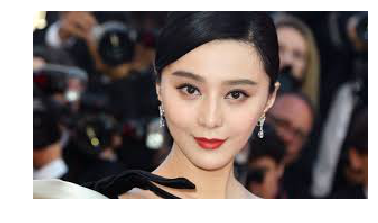

Resembled breeds and its probabilities:

Chihuahua
2.60%
Chinese crested
2.38%
Dachshund
2.03%




It's a human!


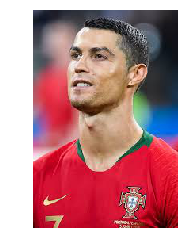

Resembled breeds and its probabilities:

Chinese crested
2.22%
Pharaoh hound
2.09%
Xoloitzcuintli
1.90%




It's a human!


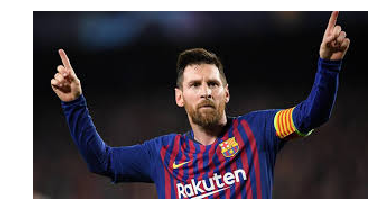

Resembled breeds and its probabilities:

Chinese crested
2.34%
Icelandic sheepdog
2.32%
Wirehaired pointing griffon
1.67%




It's a human!


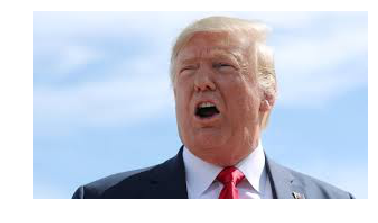

Resembled breeds and its probabilities:

Glen of imaal terrier
2.40%
Bedlington terrier
2.20%
Dandie dinmont terrier
2.16%




It's a human!


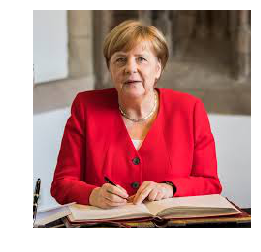

Resembled breeds and its probabilities:

Dogue de bordeaux
2.83%
Chinese crested
2.39%
Pharaoh hound
2.19%




It's a dog!


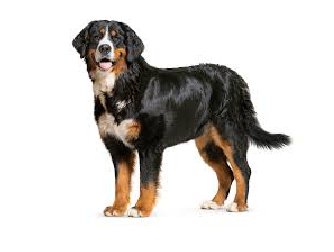

Predicted breeds and its probabilities:

Bernese mountain dog
63.59%
Entlebucher mountain dog
5.60%
Greater swiss mountain dog
4.68%




It's a dog!


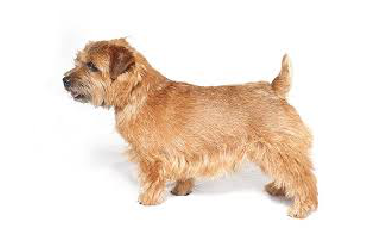

Predicted breeds and its probabilities:

Norfolk terrier
37.15%
Norwich terrier
9.40%
Cairn terrier
9.19%




It's a dog!


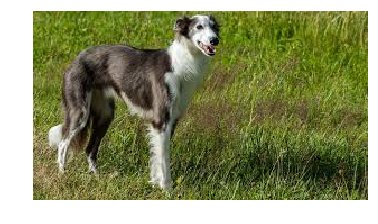

Predicted breeds and its probabilities:

Borzoi
40.34%
Greyhound
5.26%
Australian shepherd
4.61%




It's a dog!


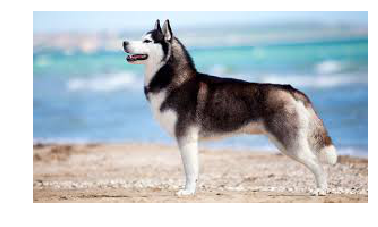

Predicted breeds and its probabilities:

Alaskan malamute
42.14%
Akita
8.85%
Norwegian lundehund
5.05%




I can't detect if it's a human or dog!


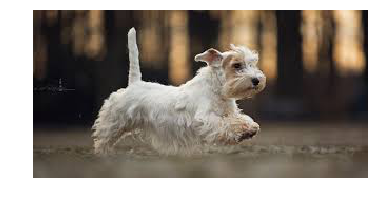





I can't detect if it's a human or dog!


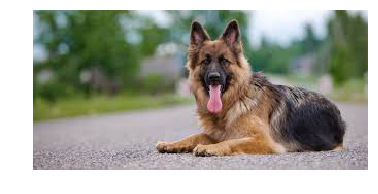





It's a dog!


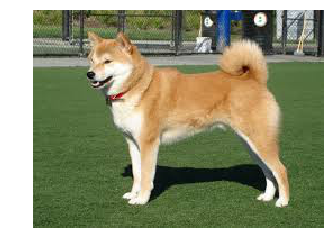

Predicted breeds and its probabilities:

Akita
39.91%
Basenji
7.13%
Icelandic sheepdog
5.69%




I can't detect if it's a human or dog!


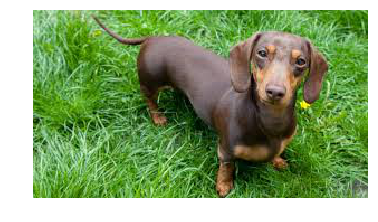





I can't detect if it's a human or dog!


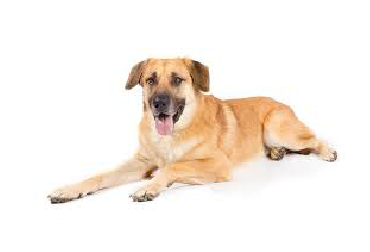





I can't detect if it's a human or dog!


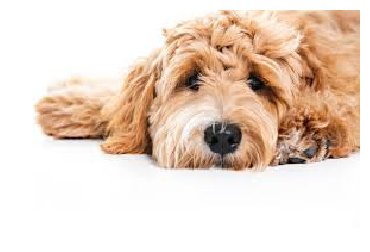

In [221]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
from torch.autograd import Variable

## suggested code, below
for file in np.hstack((human_files[:5], dog_files[:-1])):
    run_app(file)